<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230610_finetuning_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segment_anything opencv-python pycocotools matplotlib onnxruntime onnx torchmetrics wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=0a9408f330aee1db9358bd7f4a7e679de6d0dcf8642e4d853b94e1f1abc84570
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
from pathlib import Path
import os
import wget
import logging

import numpy as np
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamPredictor


logger = logging.getLogger()

model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'


def download_file(url:str, target:Path, overwrite=True) -> None:
  """Download a file from url to target and create folder"""
  os.makedirs(target.parent, exist_ok=True)

  if not target.exists() or overwrite:
    wget.download(url, str(target))


def download_checkpoint(checkpoint:str) -> Path:
  """Download a checkpoint to a cache and return local path"""
  checkpoints_available = ["sam_vit_h_4b8939.pth", "sam_vit_l_0b3195.pth", "sam_vit_b_01ec64.pth"]
  checkpoint_urls = {
      name: f"https://dl.fbaipublicfiles.com/segment_anything/{name}" for name in checkpoints_available
  }
  CACHE_PATH = os.environ.get(
      "TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints")
  )

  assert checkpoint in checkpoints_available
  checkpoint_path = Path(CACHE_PATH) / checkpoint
  download_file(checkpoint_urls[checkpoint], checkpoint_path, overwrite=False)
  return checkpoint_path

checkpoint=download_checkpoint(checkpoint)

# Load up the model with default weights
sam_model_original = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_original.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [3]:
from pathlib import Path
from typing import List, Dict
import random
import pickle

import numpy as np
from tqdm import tqdm
from skimage.io import imread
import cv2
import torch

from segment_anything.utils.transforms import ResizeLongestSide

transform = ResizeLongestSide(sam_model_original.image_encoder.img_size)

def box_xywh2xyxy(box: np.ndarray) -> np.ndarray:
  """Expects a numpy array shape Bx4"""

  if len(box)==0:
    return box

  box = box.copy()  # TODO: test if this is necessary
  box[..., 2] += box[..., 0]  # Width to x2
  box[..., 3] += box[..., 1]  # Height to y2
  return box


def preprocess_input_image(image_rgb):
  input_image = transform.apply_image(image_rgb)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model_original.preprocess(transformed_image)
  original_image_size = image_rgb.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  return input_image, input_size, original_image_size


def preprocess_image_embeddings(dataset):
  for datapoint in tqdm(dataset):
    input_image, input_size, original_image_size = preprocess_input_image(datapoint['sat'])
    datapoint['input_size'] = input_size
    datapoint['original_image_size'] = original_image_size

    input_image = input_image.to(device)
    with torch.no_grad():
      datapoint['image_embedding'] = sam_model_original.image_encoder(input_image)


def load_dataset(dataset_path: Path) -> List[Dict] :
  """
  Load and return a dataset. The dataset stored as a folder and contains each
  datapoint as a separate sub-folder. Train and test are considered two separate
  datasets. Each sub-folder has an unique tile_id as name and contains the
  following files:

  - contours.npy  # Array containing C contours extracted via cv2
  - bboxes.npy  # Array containing augmented bounding boxes for contours: Cx4
    - Shape: xywh, will be converted to xyxy by this function
  - points.npy  # Array containing all foreground and background points: (x,y,l)
    - l=0: background, l=1: foreground. Shape CxNx3
  - mask.png  # single-channel multi-class or single-class mask
  - sat.png  # RGB imagery of the tile from (orthonormalized satellite imagery)
  """

  dataset = []
  for datapoint_pth in tqdm(dataset_path.glob('*')):
    sat = imread(datapoint_pth / 'sat.png')

    # Some of the tiles are cut off and we don't get a full tile -> Skip
    if sat.shape[0]!=sat.shape[1]:
      logger.warn(f"Skipping tile with dims {sat.shape}")
      continue

    box_xywh = np.load(datapoint_pth / 'bboxes.npy')  # loaded in xywh format
    box_xyxy = box_xywh2xyxy(box_xywh)
    dataset.append({
        'tile_id': datapoint_pth.name,
        'bboxes': box_xyxy,
        'points': np.load(datapoint_pth / 'points.npy'),
        'contours': np.load(datapoint_pth / 'contours.npy', allow_pickle=True),
        'mask': imread(datapoint_pth / 'mask.png')//255,
        'sat': sat,
    })

  # Preprocess image embeddings and cache them
  cache_dir = Path('~/.cache/sam-bridges').expanduser()
  cache_file = cache_dir / f"{dataset_path.stem}_cache{dataset_path.suffix}"
  os.makedirs(cache_dir, exist_ok=True)
  if cache_file.exists():
    with open(cache_file, 'rb') as fp:
        dataset = pickle.load(fp)
  else:
    preprocess_image_embeddings(dataset)
    with open(cache_file, 'wb') as fp:
        pickle.dump(dataset, fp)

  return dataset

# TODO: Create dataset class

# Load Datasets

In [ ]:
dataset_folder = Path('drive/MyDrive/sam-bridges/datasets/munich_z16_v3')

train_dataset = load_dataset(dataset_folder / "train")
test_dataset = load_dataset(dataset_folder / "test")

168it [08:19,  2.83s/it]<ipython-input-3-f795be06dda5>:73: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f"Skipping tile with dims {sat.shape}")
308it [15:01,  2.91s/it]WARNING:root:Skipping tile with dims (256, 43, 3)
325it [15:47,  2.92s/it]
100%|██████████| 323/323 [02:12<00:00,  2.44it/s]
32it [01:39,  2.87s/it]

## Run fine tuning

In [184]:
from segment_anything.build_sam import Sam
from statistics import mean

from tqdm import tqdm, trange
import random
from segment_anything.modeling import ImageEncoderViT, MaskDecoder, PromptEncoder
random.seed(57)

def contour_to_mask(contour: np.ndarray, shape: np.ndarray) -> np.ndarray:
  mask = np.zeros(shape, np.uint8)
  cv2.drawContours(mask, [contour], -1, 255,-1)
  return mask


def validation(sam_model: Sam, test_dataset, loss_fn: torch.nn.Module, skip_empty=False, mode='boxes'):
  predictor = SamPredictor(sam_model)
  losses = []
  for test_dp in test_dataset:
    predictor.original_size = test_dp['original_image_size']
    predictor.input_size = test_dp['input_size']
    predictor.features = test_dp['image_embedding']
    predictor.is_image_set = True

    if skip_empty and len(test_dp['contours']==0):
      continue

    object_id = 0  # eval only on first object of tile
    gt_mask = contour_to_mask(test_dp['contours'][object_id], test_dp['original_image_size'])
    box = test_dp['bboxes'][0] if mode=='boxes' else None

    # Only taking a single foreground point as an input prompt
    points = [p for p in test_dp['points'][object_id] if p[2]==1]
    if len(points)>0:
      points = [points[0]]
      point_coords = np.array([p[:2] for p in points]) if mode=='points' else None
      point_labels = np.array([p[2] for p in points]) if mode=='points' else None
    else:
      point_coords, point_labels = None, None
      continue

    mask_pred, _, _ = predictor.predict(
      point_coords=point_coords,
      point_labels=point_labels,
      box=box,
      multimask_output=False,
      return_logits=True
    )

    mask_pred_tensor = torch.as_tensor(mask_pred[0, :,:], dtype=torch.float32)
    mask_pred_tensor = torch.nn.Sigmoid()(mask_pred_tensor)

    # From single channel to one channel per class:
    mask_pred_tensor = torch.stack([1-mask_pred_tensor, mask_pred_tensor], axis=1)
    gt_mask_tensor = torch.as_tensor(gt_mask > 0, dtype=torch.long)
    loss = loss_fn(mask_pred_tensor, gt_mask_tensor)

    losses.append(loss.item())

  return losses


# Set up the optimizer, hyperparameter tuning will improve performance here
# TODO: Load configuration from config file
LR = 1e-5
WD = 0
SKIP_EMPTY_TILES = False
NUM_EPOCHS = 5

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=LR, weight_decay=WD)

loss_fn = torch.nn.CrossEntropyLoss()

losses = []
val_losses = []
print("Val before training:", mean(validation(sam_model, test_dataset, loss_fn, SKIP_EMPTY_TILES, mode='points')))

for epoch in trange(NUM_EPOCHS):
  random.shuffle(train_dataset)
  epoch_losses = []
  for train_dp in train_dataset:
    input_size = train_dp['input_size']
    original_image_size = train_dp['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      if "image_embedding" not in train_dp:
        input_image = train_dp['input_image'].to(device)
        image_embedding = sam_model.image_encoder(input_image)
        train_dp['image_embedding'] = image_embedding

      # selected_box, gt_mask = select_single_box(train_dp['bboxes'], train_dp['mask'])
      mode = random.choice(['points', 'boxes'])
      object_id = random.randint(0, len(train_dp['bboxes'])-1)
      gt_mask = contour_to_mask(train_dp['contours'][object_id], train_dp['original_image_size'])
      box = train_dp['bboxes'][object_id] if mode=='boxes' else None
      point_coords = [p[:2] for p in train_dp['points'][object_id]] if mode=='points' else None
      point_labels = [p[2] for p in train_dp['points'][object_id]] if mode=='points' else None

      if box is not None:
        box = transform.apply_boxes(box, original_image_size)
        boxes_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        boxes_torch = boxes_torch[None, :]
      else:
        boxes_torch = None

      if point_coords is not None:
        point_coords = transform.apply_coords(np.array(point_coords), original_image_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device)
        labels_torch = torch.as_tensor(np.array(point_labels), dtype=torch.int, device=device)
        coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        points = (coords_torch, labels_torch)
      else:
          points = None

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=points,
          boxes=boxes_torch,
          masks=None,
      )

    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=train_dp['image_embedding'],
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

    upscaled_masks = torch.nn.Sigmoid()(upscaled_masks)

    gt_mask_resized = torch.from_numpy(np.resize(gt_mask, (1, 1, gt_mask.shape[0], gt_mask.shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.long)
    loss = loss_fn(torch.stack([1-upscaled_masks, upscaled_masks], axis=1), gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)

  epoch_val_losses = validation(sam_model, test_dataset, loss_fn, SKIP_EMPTY_TILES, mode='points')
  val_losses.append(epoch_val_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')
  print(f'Val loss: {mean(epoch_val_losses)}')

Val before training: 0.4092947062922687


 20%|██        | 1/5 [00:06<00:25,  6.47s/it]

EPOCH: 0
Mean loss: 0.318718341112875
Val loss: 0.34659208466367025


 40%|████      | 2/5 [00:14<00:22,  7.35s/it]

EPOCH: 1
Mean loss: 0.3170011542714417
Val loss: 0.33522010358368476


 60%|██████    | 3/5 [00:20<00:13,  6.86s/it]

EPOCH: 2
Mean loss: 0.3165800384139129
Val loss: 0.3375047176349454


 80%|████████  | 4/5 [00:28<00:07,  7.23s/it]

EPOCH: 3
Mean loss: 0.3159968755193539
Val loss: 0.335290550458722


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]

EPOCH: 4
Mean loss: 0.31600058244846924
Val loss: 0.3371040246835569


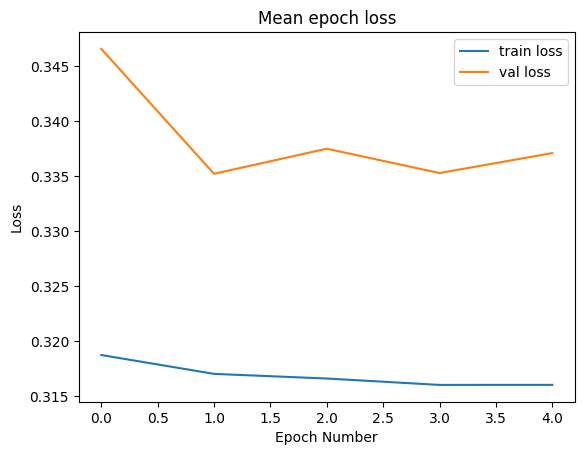

In [185]:
mean_losses = [mean(x) for x in losses]
mean_losses
mean_val_losses = [mean(x) for x in val_losses]

plt.plot(list(range(len(mean_losses))), mean_losses, label='train loss')
plt.plot(list(range(len(mean_losses))), mean_val_losses, label='val loss')
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()

plt.show()

## We can compare our tuned model to the original model

In [186]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [187]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

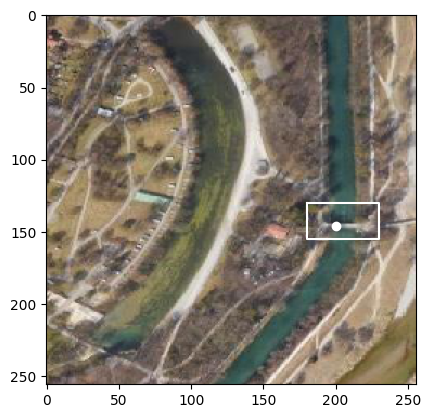

In [188]:

test_datapoint = test_dataset[1]
predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])

debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 180, 130, 50, 25
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 200, 146
plt.plot(point_x, point_y, color='white', marker = 'o')

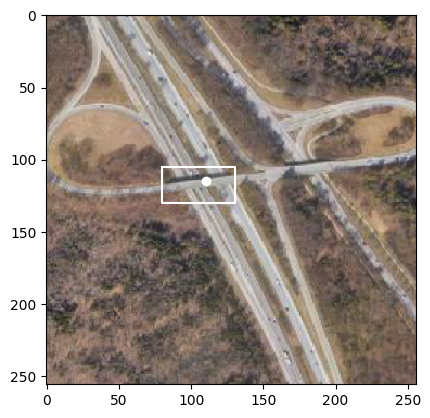

In [189]:
test_datapoint = test_dataset[13]
predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])

debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 80, 105, 50, 25
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 110, 115
plt.plot(point_x, point_y, color='white', marker = 'o')

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

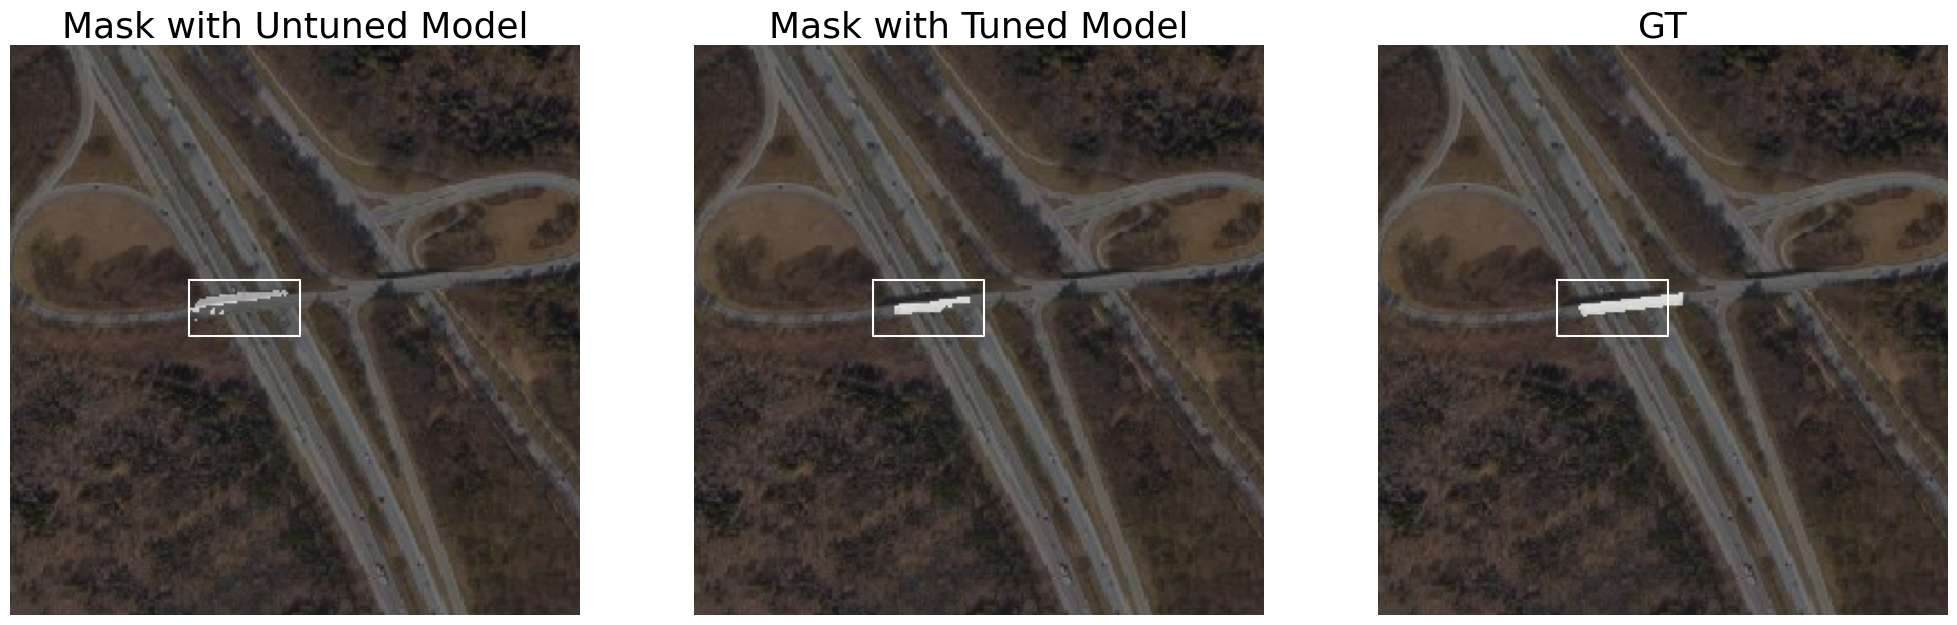

In [190]:
input_bbox = np.array(input_bbox)

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)

def sigmoid(z):
    return 1/(1 + np.exp(-z))
# TODO: Use torch.nn.Sigmoid already in predictor function. Requires custom predictor
masks_tuned = sigmoid(masks_tuned) > 0.5
masks_orig = masks_orig > 0.0


%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))

axs[0].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[0].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[0].set_title('Mask with Untuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[1].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[1].set_title('Mask with Tuned Model', fontsize=26)
axs[1].axis('off')


axs[2].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[test_datapoint['mask']*255], axis=-1)).astype(int))
axs[2].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[2].set_title('GT', fontsize=26)
axs[2].axis('off')

plt.show()

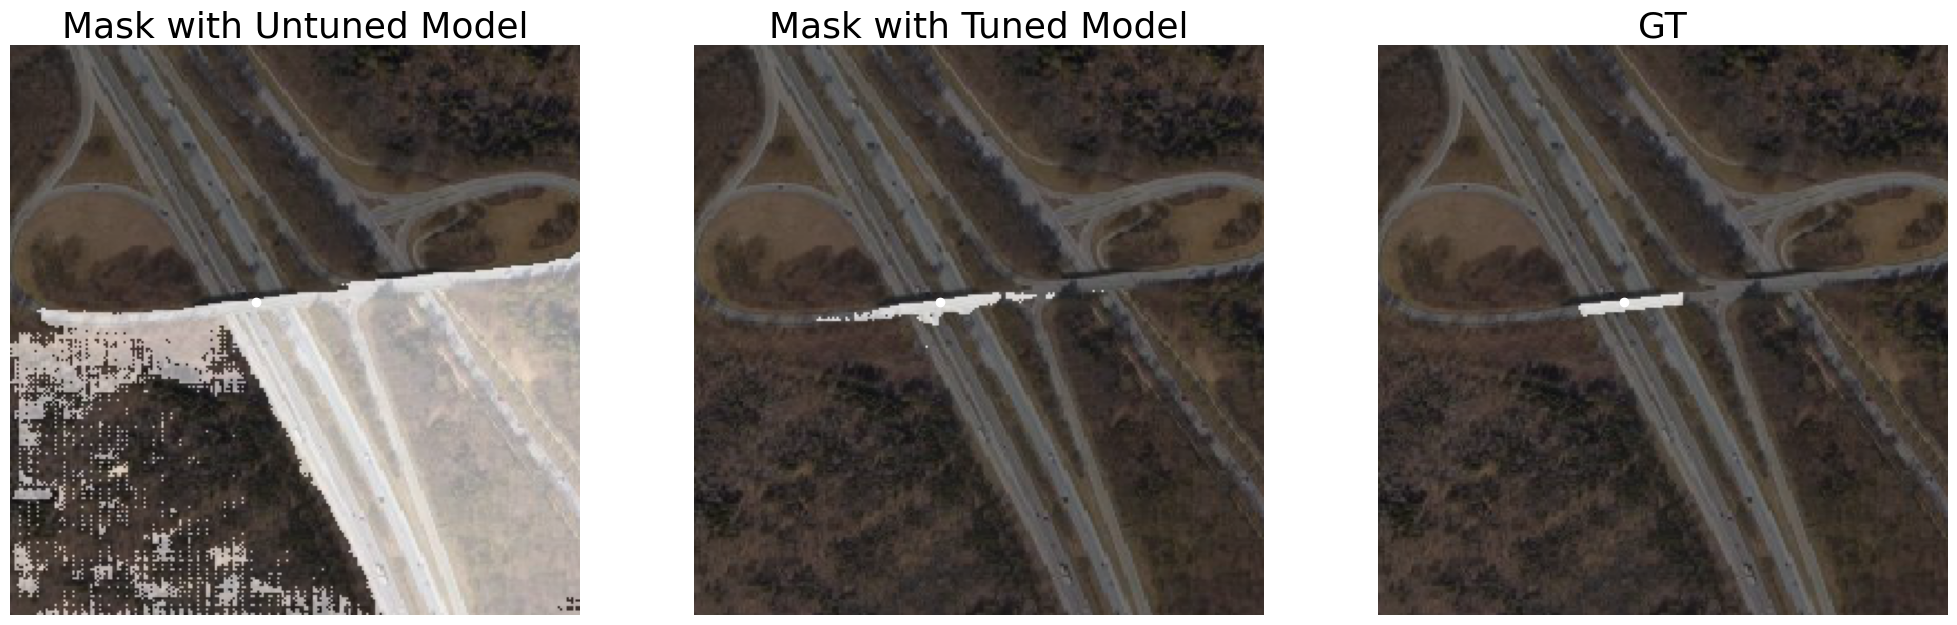

In [191]:
input_points = np.array([[point_x, point_y]])
point_labels = np.array([1])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
    return_logits=True
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
    return_logits=True
)

masks_tuned = sigmoid(masks_tuned) > 0.5
masks_orig = masks_orig > 0.0

%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))

axs[0].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[0].plot(point_x, point_y, color='white', marker = 'o')
axs[0].set_title('Mask with Untuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[1].plot(point_x, point_y, color='white', marker = 'o')
axs[1].set_title('Mask with Tuned Model', fontsize=26)
axs[1].axis('off')


axs[2].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[test_datapoint['mask']*255], axis=-1)).astype(int))
axs[2].plot(point_x, point_y, color='white', marker = 'o')
axs[2].set_title('GT', fontsize=26)
axs[2].axis('off')

plt.show()

In [192]:
masks_orig, confidences_orig, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True,
    return_logits = True
)

masks_tuned, confidences_tuned, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True,
    return_logits=True
)

masks_tuned = sigmoid(masks_tuned) > 0.5
masks_orig = masks_orig > 0.0

assert len(confidences_tuned) == len(confidences_orig)

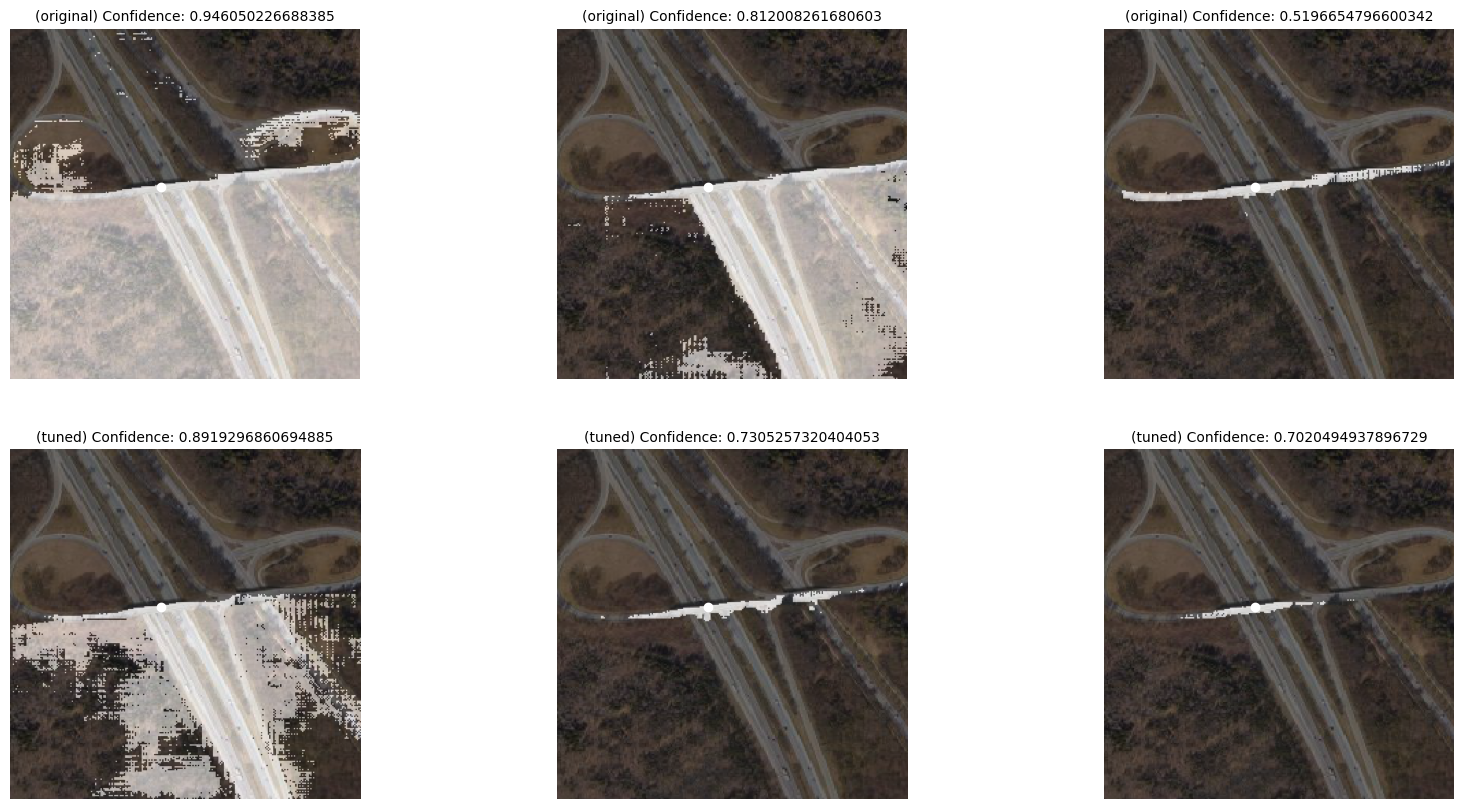

In [193]:
%matplotlib inline
_, axs = plt.subplots(2, max(len(confidences_orig), len(confidences_tuned)), figsize=(20, 10))

for ax_id in range(len(confidences_orig)):
  axs[0, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[0, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[0, ax_id].set_title(f'(original) Confidence: {confidences_orig[ax_id]}', fontsize=10)
  axs[0, ax_id].axis('off')

for ax_id in range(len(confidences_tuned)):
  axs[1, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[1, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[1, ax_id].set_title(f'(tuned) Confidence: {confidences_tuned[ax_id]}', fontsize=10)
  axs[1, ax_id].axis('off')